**Model 1**

This is a basic model of using the val dataset and training the model it does not have any optimisation yet.

This is not the final result. This model is used to show my progess in building the CNN Model.


**Imports**

In [ ]:
import os
import time
import copy
import random
from dataclasses import dataclass
from typing import List, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


**Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Set dataset paths**

In [ ]:
DATA_ROOT = "/content/drive/MyDrive/Colab Notebooks/CVNL_Assignment1"

IMAGES_DIR_CANDIDATES = [
    os.path.join(DATA_ROOT, "data", "images"),
    os.path.join(DATA_ROOT, "images"),
]
IMAGES_DIR = next((cand for cand in IMAGES_DIR_CANDIDATES if os.path.isdir(cand)), None)
if IMAGES_DIR is None:
    raise FileNotFoundError("Images folder not found.")

TXT_DIR_CANDIDATES = [os.path.join(DATA_ROOT, "data"), DATA_ROOT]
TXT_DIR = next((cand for cand in TXT_DIR_CANDIDATES if os.path.isfile(os.path.join(cand, "manufacturers.txt"))), None)
if TXT_DIR is None:
    raise FileNotFoundError("manufacturers.txt not found.")

TRAIN_TXT   = os.path.join(TXT_DIR, "images_manufacturer_train.txt")
VAL_TXT     = os.path.join(TXT_DIR, "images_manufacturer_val.txt")
TEST_TXT    = os.path.join(TXT_DIR, "images_manufacturer_test.txt")
CLASSES_TXT = os.path.join(TXT_DIR, "manufacturers.txt")

print("IMAGES_DIR:", IMAGES_DIR)
print("TXT_DIR   :", TXT_DIR)
for p in [TRAIN_TXT, VAL_TXT, TEST_TXT, CLASSES_TXT]:
    print(p, "->", "OK" if os.path.exists(p) else "MISSING")


IMAGES_DIR: /content/drive/MyDrive/Colab Notebooks/CVNL_Assignment1/images
TXT_DIR   : /content/drive/MyDrive/Colab Notebooks/CVNL_Assignment1
/content/drive/MyDrive/Colab Notebooks/CVNL_Assignment1/images_manufacturer_train.txt -> OK
/content/drive/MyDrive/Colab Notebooks/CVNL_Assignment1/images_manufacturer_val.txt -> OK
/content/drive/MyDrive/Colab Notebooks/CVNL_Assignment1/images_manufacturer_test.txt -> OK
/content/drive/MyDrive/Colab Notebooks/CVNL_Assignment1/manufacturers.txt -> OK


**Load class names and mapping**

In [ ]:
def load_classes(classes_txt: str) -> List[str]:
    with open(classes_txt, "r", encoding="utf-8") as f:
        return [line.strip() for line in f.readlines() if line.strip()]

class_names = load_classes(CLASSES_TXT)
manufacturer_to_idx = {name: i for i, name in enumerate(class_names)}

print("Num classes:", len(class_names))
print("First 10 classes:", class_names[:10])


Num classes: 30
First 10 classes: ['ATR', 'Airbus', 'Antonov', 'Beechcraft', 'Boeing', 'Bombardier Aerospace', 'British Aerospace', 'Canadair', 'Cessna', 'Cirrus Aircraft']


**Read dataset splits**

In [ ]:
def read_split(txt_path: str) -> List[Tuple[str, int]]:
    samples = []
    with open(txt_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split(" ")
            image_id = parts[0]
            label_name = " ".join(parts[1:]).strip()
            samples.append((image_id, manufacturer_to_idx[label_name]))
    return samples

train_samples = read_split(TRAIN_TXT)
val_samples   = read_split(VAL_TXT)
test_samples  = read_split(TEST_TXT)

print("Train samples:", len(train_samples))
print("Val samples  :", len(val_samples))
print("Test samples :", len(test_samples))
print("Example:", train_samples[0])


Train samples: 3334
Val samples  : 3333
Test samples : 3333
Example: ('1025794', 4)


**Dataset class with copyright banner removal**

In [ ]:
def remove_copyright_banner(pil_img: Image.Image, banner_px: int = 20) -> Image.Image:
    w, h = pil_img.size
    if h <= banner_px:
        return pil_img
    return pil_img.crop((0, 0, w, h - banner_px))

class FGVCAircraftManufacturerDataset(Dataset):
    def __init__(self, samples: List[Tuple[str, int]], images_dir: str, transform=None, banner_px: int = 20):
        self.samples = samples
        self.images_dir = images_dir
        self.transform = transform
        self.banner_px = banner_px

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_id, label = self.samples[idx]
        filename = image_id if image_id.lower().endswith(".jpg") else (image_id + ".jpg")
        img_path = os.path.join(self.images_dir, filename)
        image = Image.open(img_path).convert("RGB")
        image = remove_copyright_banner(image, banner_px=self.banner_px)
        if self.transform:
            image = self.transform(image)
        return image, label


**Define image transforms and dataloaders**

In [ ]:
IMG_SIZE = 224

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_ds = FGVCAircraftManufacturerDataset(train_samples, IMAGES_DIR, train_tfms)
val_ds   = FGVCAircraftManufacturerDataset(val_samples, IMAGES_DIR, val_tfms)
test_ds  = FGVCAircraftManufacturerDataset(test_samples, IMAGES_DIR, val_tfms)

BATCH_SIZE = 64
NUM_WORKERS = 2

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


**Define a simple CNN model**

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(True), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(True), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(True), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(True), nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

model = SimpleCNN(num_classes=len(class_names)).to(device)
print(model)


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features

**Training utilities**

In [ ]:
def run_one_epoch(model, loader, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    epoch_loss = 0.0
    all_preds, all_labels = [], []

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        if is_train:
            optimizer.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(is_train):
            logits = model(images)
            loss = criterion(logits, labels)
            if is_train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * images.size(0)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    epoch_loss /= len(loader.dataset)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)
    macro_prec = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    macro_rec = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    return epoch_loss, acc, macro_f1, macro_prec, macro_rec

@dataclass
class History:
    train_loss: list
    val_loss: list
    train_acc: list
    val_acc: list
    train_f1: list
    val_f1: list

def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3, weight_decay=0.0, save_path=None):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_wts = copy.deepcopy(model.state_dict())
    best_val_f1 = -1.0
    hist = History([], [], [], [], [], [])

    for epoch in range(1, epochs + 1):
        t0 = time.time()
        tr_loss, tr_acc, tr_f1, _, _ = run_one_epoch(model, train_loader, criterion, optimizer=optimizer)
        va_loss, va_acc, va_f1, _, _ = run_one_epoch(model, val_loader, criterion)

        hist.train_loss.append(tr_loss)
        hist.val_loss.append(va_loss)
        hist.train_acc.append(tr_acc)
        hist.val_acc.append(va_acc)
        hist.train_f1.append(tr_f1)
        hist.val_f1.append(va_f1)

        if va_f1 > best_val_f1:
            best_val_f1 = va_f1
            best_wts = copy.deepcopy(model.state_dict())
            if save_path:
                torch.save({
                    "model_state": best_wts,
                    "class_names": class_names,
                    "img_size": IMG_SIZE,
                    "banner_px": 20,
                }, save_path)

        dt = time.time() - t0
        print(f"Epoch {epoch}/{epochs} | train loss {tr_loss:.4f} acc {tr_acc:.4f} f1 {tr_f1:.4f} | "
              f"val loss {va_loss:.4f} acc {va_acc:.4f} f1 {va_f1:.4f} | {'BEST' if va_f1 == best_val_f1 else ''} | {dt:.1f}s")

    model.load_state_dict(best_wts)
    return model, hist


**Train the model**

In [ ]:
EPOCHS = 10
LR = 1e-3
OUT_DIR = os.path.join(DATA_ROOT, "outputs_model1")
os.makedirs(OUT_DIR, exist_ok=True)
CKPT_PATH = os.path.join(OUT_DIR, "model1_best.pt")

model, history = train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LR, save_path=CKPT_PATH)
print("Saved best checkpoint to:", CKPT_PATH)


Epoch 1/10 | train loss 3.0053 acc 0.2118 f1 0.0175 | val loss 2.8918 acc 0.2199 f1 0.0120 | BEST | 950.6s
Epoch 2/10 | train loss 2.9073 acc 0.2160 f1 0.0137 | val loss 2.8608 acc 0.2199 f1 0.0120 | BEST | 100.0s
Epoch 3/10 | train loss 2.8796 acc 0.2169 f1 0.0157 | val loss 2.8520 acc 0.2199 f1 0.0120 | BEST | 98.9s
Epoch 4/10 | train loss 2.8437 acc 0.2199 f1 0.0187 | val loss 2.8095 acc 0.2214 f1 0.0196 | BEST | 98.4s
Epoch 5/10 | train loss 2.8120 acc 0.2208 f1 0.0196 | val loss 2.8051 acc 0.2205 f1 0.0135 |  | 98.4s
Epoch 6/10 | train loss 2.7913 acc 0.2259 f1 0.0218 | val loss 2.8181 acc 0.2256 f1 0.0208 | BEST | 99.9s
Epoch 7/10 | train loss 2.7924 acc 0.2232 f1 0.0240 | val loss 2.7821 acc 0.2226 f1 0.0168 |  | 98.2s
Epoch 8/10 | train loss 2.7799 acc 0.2253 f1 0.0239 | val loss 2.7746 acc 0.2235 f1 0.0208 |  | 98.2s
Epoch 9/10 | train loss 2.7499 acc 0.2268 f1 0.0283 | val loss 2.7520 acc 0.2205 f1 0.0208 |  | 98.8s
Epoch 10/10 | train loss 2.7323 acc 0.2316 f1 0.0335 | val l

**Plot training curves**

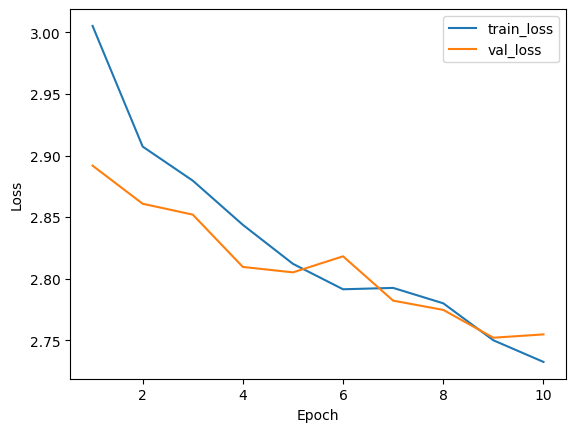

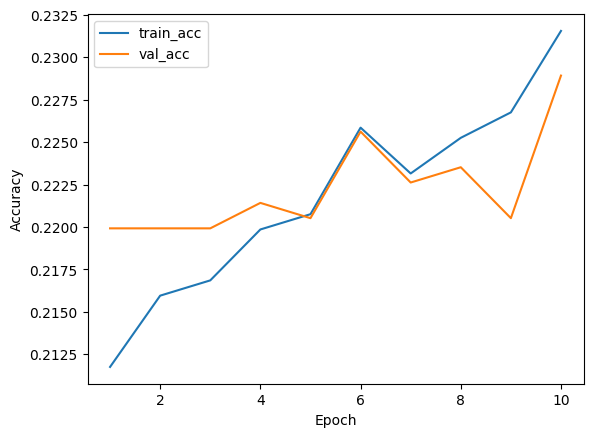

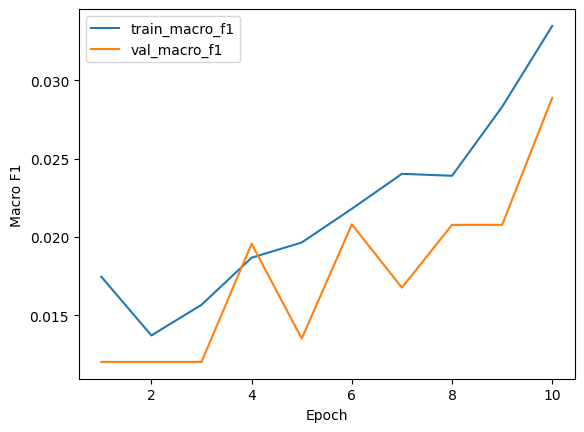

In [ ]:
def plot_history(hist: History):
    epochs = range(1, len(hist.train_loss) + 1)
    plt.figure(); plt.plot(epochs, hist.train_loss, label="train_loss"); plt.plot(epochs, hist.val_loss, label="val_loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()
    plt.figure(); plt.plot(epochs, hist.train_acc, label="train_acc"); plt.plot(epochs, hist.val_acc, label="val_acc"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.show()
    plt.figure(); plt.plot(epochs, hist.train_f1, label="train_macro_f1"); plt.plot(epochs, hist.val_f1, label="val_macro_f1"); plt.xlabel("Epoch"); plt.ylabel("Macro F1"); plt.legend(); plt.show()

plot_history(history)


**Evaluate on validation**

Validation Metrics:
Accuracy: 0.22892289228922894
Macro Precision: 0.025583695011706778
Macro Recall: 0.049114965471186274
Macro F1: 0.0288899423299136
                          precision    recall  f1-score   support

                     ATR       0.00      0.00      0.00        67
                  Airbus       0.00      0.00      0.00       433
                 Antonov       0.00      0.00      0.00        33
              Beechcraft       0.00      0.00      0.00        67
                  Boeing       0.23      0.95      0.37       733
    Bombardier Aerospace       0.00      0.00      0.00        34
       British Aerospace       0.20      0.08      0.12       134
                Canadair       0.00      0.00      0.00       133
                  Cessna       0.00      0.00      0.00       133
         Cirrus Aircraft       0.00      0.00      0.00        33
       Dassault Aviation       0.00      0.00      0.00        66
                 Dornier       0.00      0.00      0.00

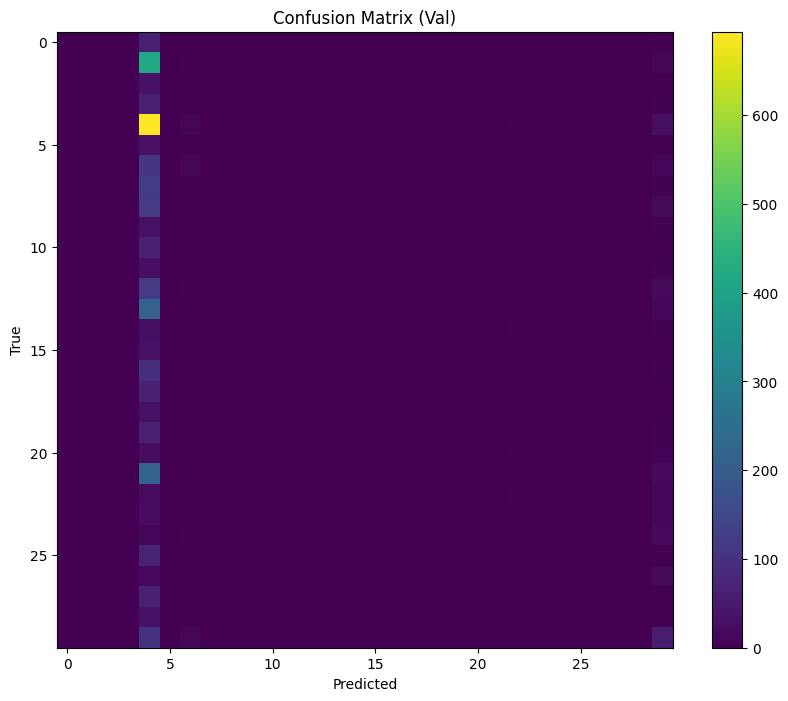

In [ ]:
def collect_preds(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            logits = model(images)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.concatenate(all_labels), np.concatenate(all_preds)

y_true, y_pred = collect_preds(model, val_loader)

val_acc = accuracy_score(y_true, y_pred)
val_macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
val_macro_prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
val_macro_rec = recall_score(y_true, y_pred, average="macro", zero_division=0)

print("Validation Metrics:")
print("Accuracy:", val_acc)
print("Macro Precision:", val_macro_prec)
print("Macro Recall:", val_macro_rec)
print("Macro F1:", val_macro_f1)
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8)); plt.imshow(cm, interpolation="nearest"); plt.title("Confusion Matrix (Val)"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.colorbar(); plt.show()


**Save metrics summary**

In [ ]:
import json
metrics_path = os.path.join(OUT_DIR, "model1_val_metrics.json")
with open(metrics_path, "w") as f:
    json.dump({
        "val_accuracy": float(val_acc),
        "val_macro_precision": float(val_macro_prec),
        "val_macro_recall": float(val_macro_rec),
        "val_macro_f1": float(val_macro_f1),
        "epochs": EPOCHS,
        "lr": LR,
        "img_size": IMG_SIZE,
        "batch_size": BATCH_SIZE,
        "banner_px_removed": 20
    }, f, indent=2)
print("Saved metrics to:", metrics_path)


Saved metrics to: /content/drive/MyDrive/Colab Notebooks/CVNL_Assignment1/outputs_model1/model1_val_metrics.json
